In [ ]:
from datasets import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip -q install datasets

Загрузили датасет

In [ ]:
df = pd.read_csv('/content/Tweets.csv')

Смотрим данные

In [ ]:
print(df.head())

       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative  


Смотрим пропуски

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


Удаляем пропуски

In [ ]:
df = df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


Функция для предварительной обработки текста

In [ ]:
def preprocess_text(text):
    text = re.sub(r'<.*?>|http\S+', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    cleaned_text = ' '.join(tokens)
    return cleaned_text

df['cleaned_text'] = df['text'].apply(preprocess_text)

Инициализация TF-IDF векторизатора

Преобразуем очищенные тексты в матрицу TF-IDF признаков

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(df['cleaned_text'])

Делим на тренировочную и тестовую выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_vectors, df['sentiment'], test_size=0.2, random_state=42)

Инифиализация, обучение и предсказание модели логистической регрессии

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

Вывод метрик

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Logistic Regression - Accuracy: {accuracy:.2f}')
print(f'Logistic Regression - Precision: {precision:.2f}')
print(f'Logistic Regression - Recall: {recall:.2f}')
print(f'Logistic Regression - F1 Score: {f1:.2f}')

Logistic Regression - Accuracy: 0.68
Logistic Regression - Precision: 0.69
Logistic Regression - Recall: 0.68
Logistic Regression - F1 Score: 0.68


Вывод confusion matrix

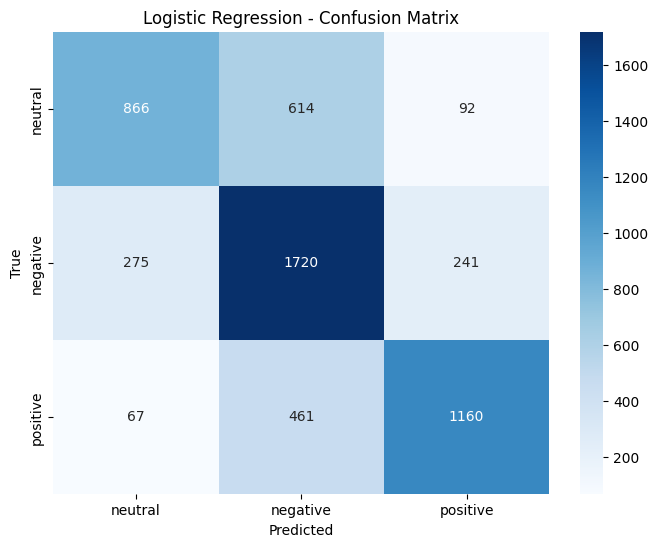

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['sentiment'].unique(), yticklabels=df['sentiment'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression - Confusion Matrix')
plt.show()

Загружаем токенизатор и модель BERT для классификации

In [ ]:
tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')
model= BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Токенизация текста - преобразование в последовательность токенов

In [ ]:
encoded_data= tokenizer.batch_encode_plus(df['text'].tolist(), max_length=128, padding=True, truncation=True, return_tensors='pt')
input_ids= encoded_data['input_ids']
attention_masks= encoded_data['attention_mask']

Преобразование меток в числовые значения

In [ ]:
labels= torch.tensor(df['sentiment'].map({'positive': 0, 'negative': 1, 'neutral': 2}).values)

Разделение данных на тренировочную и валидационную выборки

In [ ]:
train_inputs, val_inputs, train_labels, val_labels= train_test_split(input_ids, labels, test_size= 0.2, random_state= 42)
train_masks, val_masks, _, _= train_test_split(attention_masks, input_ids, test_size= 0.2, random_state= 42)

Функция для конвертации данных в формат Dataset

In [ ]:
def convert_to_dataset(input_ids, attention_masks, labels):
    dataset = Dataset.from_dict({
        'input_ids': input_ids.numpy(),
        'attention_mask': attention_masks.numpy(),
        'labels': labels.numpy()
    })
    return dataset

In [ ]:
train_dataset= convert_to_dataset(train_inputs, train_masks, train_labels)
val_dataset= convert_to_dataset(val_inputs, val_masks, val_labels)

Создаем объект для правильной обработки батсей с разной длиной последоватльности

In [ ]:
data_collator= DataCollatorWithPadding(tokenizer)

training_args= TrainingArguments(output_dir='./bert_output', num_train_epochs=1, per_device_train_batch_size=16, per_device_eval_batch_size=64, warmup_steps=500, weight_decay=0.01, logging_dir='./logs', report_to= 'none')

Trainer будет управлять процессом обучения


Обучаем

In [ ]:
trainer= Trainer(model= model, args= training_args, train_dataset= train_dataset, eval_dataset= val_dataset, data_collator= data_collator, tokenizer= tokenizer)

trainer.train()

<ipython-input-25-3c79756e212f>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer= Trainer(model= model, args= training_args, train_dataset= train_dataset, eval_dataset= val_dataset, data_collator= data_collator, tokenizer= tokenizer)


Step,Training Loss
500,0.803100
1000,0.593800


TrainOutput(global_step=1374, training_loss=0.6502332395861763, metrics={'train_runtime': 466.2798, 'train_samples_per_second': 47.148, 'train_steps_per_second': 2.947, 'total_flos': 1242717561106560.0, 'train_loss': 0.6502332395861763, 'epoch': 1.0})

Оценка модели

In [ ]:
model.eval()
predictions= []
true_labels= []

In [ ]:
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=32)

Прогоняем модель на валидационных данных и собираем предсказания

In [ ]:
with torch.no_grad():
    for batch in val_dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        outputs = model(**inputs)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = batch[2].to('cpu').numpy()
        predictions.extend(np.argmax(logits, axis=1))
        true_labels.extend(label_ids)

Вывод метрик

In [ ]:
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'BERT - Accuracy: {accuracy:.2f}')
print(f'BERT - Precision: {precision:.2f}')
print(f'BERT - Recall: {recall:.2f}')
print(f'BERT - F1 Score: {f1:.2f}')

BERT - Accuracy: 0.80
BERT - Precision: 0.80
BERT - Recall: 0.80
BERT - F1 Score: 0.80


Вывод confusion matrix

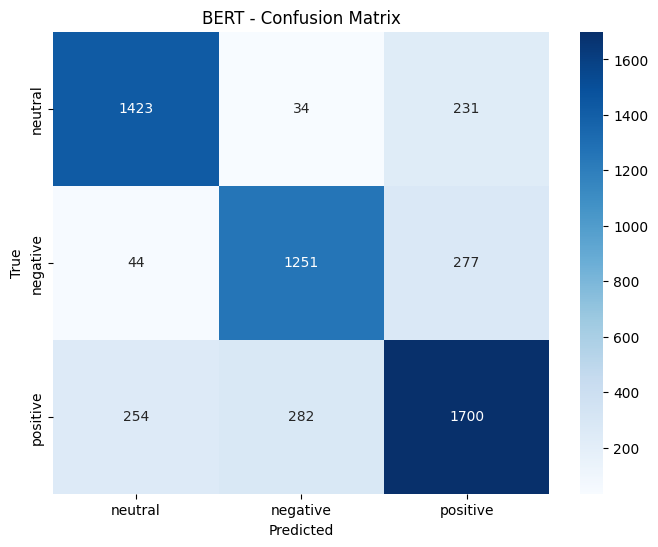

In [ ]:
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['sentiment'].unique(), yticklabels=df['sentiment'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BERT - Confusion Matrix')
plt.show()